# Crete 2D data replicates for runtime analysis

In [6]:
import numpy as np
import glob
import json
import random
import math

from qilin.parse_lsdyna_simulation import parse_simulation, parse_simulation_strain         


dataset = 'Concrete2D-C-runtime-analysis'
in_dir = f'/home/jovyan/share/gns_data/Concrete2D-DYNA/'
out_dir = f'/home/jovyan/share/gns_data/{dataset}/'
# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir + 'coordinates_eps/*.txt')
random.shuffle(simulations)

## Larger step size leads to shorter trajectory and hence better rollout performance
## But lower precision of the simulation
## Current simulation are of absolute time 0.5 seconds
## Step size=1 means 500 steps, each of which 1 ms
## step size=5 means 100 steps, each of which 5 ms
STEP_SIZE = 5

## For the pnormalisation of data
# strain_C_mean = 1.138
# strain_C_std = 0.831
# strain_I_mean = 1.503
# strain_I_std = 0.735
MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
strain_min, strain_max = 0, 2

## Fixed hold-out validation and testing, for reproducibility
## GNN performance seems better with cases of larger loading (higher contact velocity) 
I_valid_trajectory = ['B_80_320_Aa_120', 'B_80_480_Ac_120', 'R_80_320_Aa_80', 'R_80_480_Ab_160', 
                      'R_80_640_Ac_160', 'S_80_320_Aa_160', 'S_80_480_Ab_80', 'S_80_640_Ac_120']

I_test_trajectory = ['B_80_320_Aa_80', 'B_80_480_Ac_160', 'R_80_320_Aa_160', 'R_80_480_Ab_120', 
                     'R_80_640_Ac_120', 'S_80_320_Aa_120', 'S_80_480_Ab_160', 'S_80_640_Ac_160']

C_valid_trajectory = ['C_80_320_Aa_12', 'C_80_320_Bc_8', 'C_80_320_Ca_16', 'C_80_320_Cb_20', 'C_80_480_Ab_20', 
                      'C_80_480_Bb_12', 'C_80_480_Cc_20', 'C_80_480_Ca_16', 'C_80_640_Aa_16', 'C_80_640_Bb_12']

C_test_trajectory = ['C_80_320_Aa_16', 'C_80_320_Bc_12', 'C_80_320_Ca_20', 'C_80_320_Cb_16', 'C_80_480_Ab_16', 
                     'C_80_480_Bb_8', 'C_80_480_Cc_12', 'C_80_480_Ca_20', 'C_80_640_Aa_12', 'C_80_640_Bb_20']

## Different datasets have different parameters
if 'Concrete2D-I' in dataset:
    simulations = [f for f in simulations if "C_" not in f and "40." not in f]
    valid_trajectory = I_valid_trajectory
    test_trajectory = I_test_trajectory
    MAX = MAX_I
    MIN = MIN_I
elif 'Concrete2D-C' in dataset:
    simulations = [f for f in simulations if "C_" in f]
    valid_trajectory = C_valid_trajectory
    test_trajectory = C_test_trajectory
    MAX = MAX_C
    MIN = MIN_C
else:
    print("Dataset not found!")

## Initialisation placeholders for data
n_trajectory = len(simulations)
ds_train, ds_valid, ds_test = {}, {}, {}
vels = np.array([]).reshape(0, 2)
accs = np.array([]).reshape(0, 2)
file_train, file_valid, file_test = [], [], []

## Main loop for data extraction
for idx, simulation in enumerate(simulations):
    if idx == 20: break
    print(f"{idx}/{n_trajectory} Reading {simulation}...")
    positions, particle_types, strains = parse_simulation(simulation)
    max_principal_strains = parse_simulation_strain(simulation)
    
    # For constant velocity, get rid of the last 4 boundary particles
    traj_name = simulation.split('/')[-1][:-4]
    if traj_name.startswith('C'):
        positions = positions[::1,:-4:1,::1]
        particle_types = particle_types[:-4]
        strains = strains[::1, :-4:1]
        max_principal_strains = max_principal_strains[::1, :-4:1]
        
    ## Preprocessing position
    # Normalisation to [0, 1]
    positions = positions[::STEP_SIZE,::1,::1]
    positions = (positions - MIN) / (MAX - MIN) 
    
    # After normalisation the y-axis of beam is stretched
    # Apply a scalling factor to retain x/y ratio
    # so that the shape of beam does not change
    # it also means the connection radius will work similarlly for both x and y
    y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
    positions[:,:,1] = positions[:,:,1] / y_scaling_factor  
    
    strains = strains[::STEP_SIZE, ::1]
    strains = (strains - strain_min) / (strain_max - strain_min)
    ## Standardisation maeks more sense but empirically not so
    # strains = (strains - strain_mean) / strain_std
    
    # Preprocessing mps
    # raw mps contains many small value like 1e-8, 1e-39 and negative 1e-7
    # while negative value has physical meaning, it is too small
    # No normalisation is performed as empirically reduces performance
    max_principal_strains = max_principal_strains[::STEP_SIZE, ::1]
    max_principal_strains[max_principal_strains < 1e-8] = 0
    
    ## Crete replicates of data for runtime analysis
    for replicate in range(random.randint(2, 4)):
        mask = particle_types== 0
        pos = positions[:, mask, :]
        pos[:,:,0] +=  + 2**replicate
        positions = np.concatenate((positions, pos), axis=1)
        par = particle_types[mask]
        particle_types = np.concatenate((particle_types, par))
        mps =  max_principal_strains[:, mask]
        max_principal_strains = np.concatenate((max_principal_strains, mps), axis=1)
        
    # print for debug
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"EPS min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"MPS min:{max_principal_strains.min(axis=(0,1))}, max:{max_principal_strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_types.shape}, EPS: {strains.shape}, MPS: {max_principal_strains.shape}")
    print(f"Unique particle types: {np.unique(particle_types)}")
    
    # Data splits: train(80%), valid(10%), test(10%)
    key = 'trajectory_' + str(idx)
    ds_test[key] = [positions, particle_types, max_principal_strains]
    file_test.append(f'{traj_name}_N{particle_types.shape[0]}')
        
    # Extract Vel and Acc statistics
    # positions of shape [timestep, particles, dimensions]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:]- vel_trajectory[:-1,:,:]
    
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, 2)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, 2)), axis=0)

# Extract vel, acc statistics for normalisation
vel_mean, vel_std = list(vels.mean(axis=0)), list(vels.std(axis=0))
acc_mean, acc_std = list(accs.mean(axis=0)), list(accs.std(axis=0))

# Save datasets in numpy format
np.savez(out_dir + 'train.npz', **ds_train)
np.savez(out_dir + 'valid.npz', **ds_valid)
np.savez(out_dir + 'test.npz', **ds_test)

print(f"{len(ds_train)} trajectories saved to train.npz.")
print(f"{len(ds_valid)} trajectories saved to valid.npz.")
print(f"{len(ds_test)}  trajectories saved to test.npz.")

# Save meta data
in_file = '/home/jovyan/share/gns_data/WaterDropSample/metadata.json'
out_file = f'/home/jovyan/share/gns_data/{dataset}/metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

# meta_data['bounds'] = [[-200, 200], [0, 100]]
# The origin of simulation domain is at bottom center, and x in [-165, 165], y in [-10, 85].
# Particle radius r is 1.25 mm, and the connection Radius R is around 6r to 7r, or [7.5, 8.75] (24 neighbors, maybe more)
# In GNN, the suggested connection radius is 4.5r, or 5.625 mm (aounrd 20 neighbors)
# If R is 6mm before normalization, then it is 0.016 where 6/370 = x/1

# 0.04 (normalized) or 7.5 (unnormalized) for around 24 neighbours
# Note this parameter has been surpassed by another one in train.py
meta_data['default_connectivity_radius'] = 0.01 
meta_data['sequence_length'] = positions.shape[0]
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
# meta_data['strain_mean'] = strain_mean
# meta_data['strain_std'] = strain_std

meta_data['dt'] = 0.001 * STEP_SIZE
if 'Concrete2D-C' in dataset:
    meta_data['bounds'] = [[0,1], [0, 0.17]]
else:
    meta_data['bounds'] = [[0,1], [0, 0.25]]
meta_data['file_train'] = file_train
meta_data['file_valid'] = file_valid
meta_data['file_test'] = file_test
print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

0/108 Reading /home/jovyan/share/gns_data/Concrete2D-DYNA/coordinates_eps/C_80_640_Bc_12.txt...
Position min:[0.00693634 0.00192168], max:[15.99505738  0.16761538]
EPS min:0.0, max:0.999666
MPS min:0.0, max:0.427454
Shape, pos: (101, 131040, 2), types: (131040,), EPS: (101, 8280), MPS: (101, 131040)
Unique particle types: [0. 1. 3.]
1/108 Reading /home/jovyan/share/gns_data/Concrete2D-DYNA/coordinates_eps/C_80_480_Cb_20.txt...
Position min:[0.12913182 0.00192031], max:[3.87633091 0.16761538]
EPS min:0.0, max:1.0
MPS min:0.0, max:1.525337
Shape, pos: (101, 24640, 2), types: (24640,), EPS: (101, 6232), MPS: (101, 24640)
Unique particle types: [0. 1. 3.]
2/108 Reading /home/jovyan/share/gns_data/Concrete2D-DYNA/coordinates_eps/C_80_320_Bb_8.txt...
Position min:[0.25156797 0.00192109], max:[7.75082957 0.16761538]
EPS min:0.0, max:0.9997735
MPS min:0.0, max:0.70481
Shape, pos: (101, 32800, 2), types: (32800,), EPS: (101, 4184), MPS: (101, 32800)
Unique particle types: [0. 1. 3.]
3/108 Readi

In [38]:
mask = particle_types==0
a = positions[:,mask,:]
b = np.concatenate((positions, a), axis=1)
b[:,:,0] -= 640
b[:,8284:,:].min(axis=(0,1))

array([-960.13608  ,   -3.0696322])

In [2]:
particle_types.shape[0]

16464

# Generate Concrete 2D data for generalizibility test

In [58]:
import numpy as np
import glob
import json
import random
import math

from parse_lsdyna_simulation import parse_simulation, parse_simulation_strain         


dataset = 'Concrete2D-C-generalize'
in_dir = f'/home/jovyan/share/gns_data/Concrete2D-DYNA/'
out_dir = f'/home/jovyan/share/gns_data/{dataset}/'
# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir + 'coordinates_eps/*.txt')
random.shuffle(simulations)

## Larger step size leads to shorter trajectory and hence better rollout performance
## But lower precision of the simulation
## Current simulation are of absolute time 0.5 seconds
## Step size=1 means 500 steps, each of which 1 ms
## step size=5 means 100 steps, each of which 5 ms
STEP_SIZE = 5

## For the pnormalisation of data
# strain_C_mean = 1.138
# strain_C_std = 0.831
# strain_I_mean = 1.503
# strain_I_std = 0.735
MAX_I = np.array([325, 150])
MIN_I = np.array([-325, -30])
MAX_C = np.array([325, 95])
MIN_C = np.array([-325, -15])
strain_min, strain_max = 0, 2

## Fixed hold-out validation and testing, for reproducibility
## GNN performance seems better with cases of larger loading (higher contact velocity) 
I_valid_trajectory = ['B_80_320_Aa_120', 'B_80_480_Ac_120', 'R_80_320_Aa_80', 'R_80_480_Ab_160', 
                      'R_80_640_Ac_160', 'S_80_320_Aa_160', 'S_80_480_Ab_80', 'S_80_640_Ac_120']

I_test_trajectory = ['B_80_320_Aa_80', 'B_80_480_Ac_160', 'R_80_320_Aa_160', 'R_80_480_Ab_120', 
                     'R_80_640_Ac_120', 'S_80_320_Aa_120', 'S_80_480_Ab_160', 'S_80_640_Ac_160']

C_valid_trajectory = ['C_80_320_Aa_12', 'C_80_320_Bc_8', 'C_80_320_Ca_16', 'C_80_320_Cb_20', 'C_80_480_Ab_20', 
                      'C_80_480_Bb_12', 'C_80_480_Cc_20', 'C_80_480_Ca_16', 'C_80_640_Aa_16', 'C_80_640_Bb_12']

C_test_trajectory = ['C_80_320_Aa_16', 'C_80_320_Bc_12', 'C_80_320_Ca_20', 'C_80_320_Cb_16', 'C_80_480_Ab_16', 
                     'C_80_480_Bb_8', 'C_80_480_Cc_12', 'C_80_480_Ca_20', 'C_80_640_Aa_12', 'C_80_640_Bb_20']

## Different datasets have different parameters
if 'Concrete2D-I' in dataset:
    simulations = [f for f in simulations if "C_" not in f and "trapolation" in f]
    valid_trajectory = I_valid_trajectory
    test_trajectory = I_test_trajectory
    MAX = MAX_I
    MIN = MIN_I
elif 'Concrete2D-C' in dataset:
    simulations = [f for f in simulations if "C_" in f and "trapolation" in f]
    valid_trajectory = C_valid_trajectory
    test_trajectory = C_test_trajectory
    MAX = MAX_C
    MIN = MIN_C
else:
    print("Dataset not found!")

## Initialisation placeholders for data
n_trajectory = len(simulations)
ds_train, ds_valid, ds_test = {}, {}, {}
vels = np.array([]).reshape(0, 2)
accs = np.array([]).reshape(0, 2)
file_train, file_valid, file_test = [], [], []

## Main loop for data extraction
for idx, simulation in enumerate(simulations):
    print(f"{idx}/{n_trajectory} Reading {simulation}...")
    positions, particle_types, eps = parse_simulation(simulation)
    ## Skip the first timestep due to raw data error
    positions = positions[1:, :, :]
    eps = eps[1:, :]
    
    # For constant velocity, get rid of the last 4 boundary particles
    traj_name = simulation.split('/')[-1][:-4]
    if traj_name.startswith('C'):
        positions = positions[::1,:-4:1,::1]
        particle_types = particle_types[:-4]
        eps = eps[::1, :-4:1]
        
    ## Preprocessing position
    # Normalisation to [0, 1]
    positions = positions[::STEP_SIZE,::1,::1]    
    positions = (positions - MIN) / (MAX - MIN) 
    
    # After normalisation the y-axis of beam is stretched
    # Apply a scalling factor to retain x/y ratio
    # so that the shape of beam does not change
    # it also means the connection radius will work similarlly for both x and y
    y_scaling_factor = (MAX - MIN)[0] / (MAX - MIN)[1]
    positions[:,:,1] = positions[:,:,1] / y_scaling_factor  
    
    # Preprocessing eps
    # Currently [0,1] normalisation in use
    # This is actually unnecessary as the raw range is [0,2]
    # Scale it down to [0, 1] effectively reduces the contribution of eps in loss function
    # TODO: Probbably can leave it raw in the future
    eps = eps[::STEP_SIZE, ::1]
    # eps[eps < 1e-8] = 0
    eps = (eps - strain_min) / (strain_max - strain_min)
    ## Standardisation maeks more sense but empirically not so
    # strains = (strains - strain_mean) / strain_std
    
    # Preprocessing mps
    # raw mps contains many small value like 1e-8, 1e-39 and negative 1e-7
    # while negative value has physical meaning, it is too small
    # No normalisation is performed as empirically reduces performance
    if 'mps' in dataset:
        mps = parse_simulation_strain(simulation)
        mps = mps[1:, :]
        if traj_name.startswith('C'):
            mps = mps[::1, :-4:1]
        mps = mps[::STEP_SIZE, ::1]
        # mps[mps < 1e-6] = 0
        mps[mps>100]=1
    
    strains = mps if 'mps' in dataset else eps
    
    
    # print for debug
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_types.shape}, strain: {strains.shape}")
    print(f"Unique particle types: {np.unique(particle_types)}")
    
    # Data splits: train(80%), valid(10%), test(10%)
    key = 'trajectory_' + str(idx)
    print('to test')
    ds_test[key] = [positions, particle_types, strains]
    file_test.append(traj_name)
        
    # Extract Vel and Acc statistics
    # positions of shape [timestep, particles, dimensions]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:]- vel_trajectory[:-1,:,:]
    
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, 2)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, 2)), axis=0)

# Extract vel, acc statistics for normalisation
vel_mean, vel_std = list(vels.mean(axis=0)), list(vels.std(axis=0))
acc_mean, acc_std = list(accs.mean(axis=0)), list(accs.std(axis=0))

# Save datasets in numpy format
np.savez(out_dir + 'train.npz', **ds_train)
np.savez(out_dir + 'valid.npz', **ds_valid)
np.savez(out_dir + 'test.npz', **ds_test)

print(f"{len(ds_train)} trajectories saved to train.npz.")
print(f"{len(ds_valid)} trajectories saved to valid.npz.")
print(f"{len(ds_test)}  trajectories saved to test.npz.")

# Save meta data
in_file = '/home/jovyan/share/gns_data/WaterDropSample/metadata.json'
out_file = f'/home/jovyan/share/gns_data/{dataset}/metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

# meta_data['bounds'] = [[-200, 200], [0, 100]]
# The origin of simulation domain is at bottom center, and x in [-165, 165], y in [-10, 85].
# Particle radius r is 1.25 mm, and the connection Radius R is around 6r to 7r, or [7.5, 8.75] (24 neighbors, maybe more)
# In GNN, the suggested connection radius is 4.5r, or 5.625 mm (aounrd 20 neighbors)
# If R is 6mm before normalization, then it is 0.016 where 6/370 = x/1

# 0.04 (normalized) or 7.5 (unnormalized) for around 24 neighbours
# Note this parameter has been surpassed by another one in train.py
meta_data['default_connectivity_radius'] = 0.01 
meta_data['sequence_length'] = positions.shape[0]
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
# meta_data['strain_mean'] = strain_mean
# meta_data['strain_std'] = strain_std

meta_data['dt'] = 0.001 * STEP_SIZE
if 'Concrete2D-C' in dataset:
    meta_data['bounds'] = [[0,1], [0, 0.17]]
else:
    meta_data['bounds'] = [[0,1], [0, 0.25]]
meta_data['file_train'] = file_train
meta_data['file_valid'] = file_valid
meta_data['file_test'] = file_test
print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

dataset_in = dataset.split('-ge')[0]
in_file = '/home/jovyan/share/gns_data/Concrete2D-I-mps/metadata.json'
out_file = f'/home/jovyan/share/gns_data/{dataset}/metadata.json'

with open(in_file, 'r') as f:
    meta_data_in = json.load(f)

with open(out_file, 'r') as f:
    meta_data_out = json.load(f)

print(meta_data_out)

for field in ['vel_mean', 'vel_std', 'acc_mean', 'acc_std']:
    meta_data_out[field] = meta_data_in[field]

print(meta_data_out)

with open(out_file, 'w') as f:
    json.dump(meta_data_out, f)

0/3 Reading /home/jovyan/share/gns_data/Concrete2D-DYNA/coordinates_eps/C_60_240_V22_extrapolation.txt...
Position min:[0.31112153 0.00191844], max:[0.69969061 0.13681515]
Strain min:0.0, max:0.999888
Shape, pos: (101, 2394, 2), types: (2394,), strain: (101, 2394)
Unique particle types: [0. 1. 3.]
to test
1/3 Reading /home/jovyan/share/gns_data/Concrete2D-DYNA/coordinates_eps/C_80_560_V14_intrapolation.txt...
Position min:[0.06835448 0.00192082], max:[0.93575197 0.16759565]
Strain min:0.0, max:0.9997055
Shape, pos: (101, 7256, 2), types: (7256,), strain: (101, 7256)
Unique particle types: [0. 1. 3.]
to test
2/3 Reading /home/jovyan/share/gns_data/Concrete2D-DYNA/coordinates_eps/C_60_240_V6_extrapolation.txt...
Position min:[0.31462449 0.00192092], max:[0.68881378 0.13683769]
Strain min:0.0, max:0.9997445
Shape, pos: (101, 2394, 2), types: (2394,), strain: (101, 2394)
Unique particle types: [0. 1. 3.]
to test
0 trajectories saved to train.npz.
0 trajectories saved to valid.npz.
3  traje

# Modify Metadata

In [56]:
in_file = '/home/jovyan/share/gns_data/Concrete2D-I-mps/metadata.json'
out_file = f'/home/jovyan/share/gns_data/Concrete2D-I-mps-generalize/metadata.json'

with open(in_file, 'r') as f:
    meta_data_in = json.load(f)

with open(out_file, 'r') as f:
    meta_data_out = json.load(f)

print(meta_data_out)

for field in ['vel_mean', 'vel_std', 'acc_mean', 'acc_std']:
    meta_data_out[field] = meta_data_in[field]

print(meta_data_out)

with open(out_file, 'w') as f:
    json.dump(meta_data_out, f)

{'bounds': [[0, 1], [0, 0.25]], 'sequence_length': 101, 'default_connectivity_radius': 0.01, 'dim': 2, 'dt': 0.005, 'vel_mean': [-1.7115771222289788e-07, -2.299100925667521e-05], 'vel_std': [3.8464104603199213e-05, 6.598799710045874e-05], 'acc_mean': [-1.3207815706569187e-09, -9.173410756125413e-08], 'acc_std': [3.8382434931217085e-06, 6.768502644988062e-06], 'file_train': [], 'file_valid': [], 'file_test': ['S_80_400_V140_intrapolation', 'S_100_800_V60_extrapolation']}
{'bounds': [[0, 1], [0, 0.25]], 'sequence_length': 101, 'default_connectivity_radius': 0.01, 'dim': 2, 'dt': 0.005, 'vel_mean': [3.8072616559548704e-08, -4.643266774997372e-05], 'vel_std': [4.735423637358874e-05, 8.597259247133063e-05], 'acc_mean': [4.278994566819095e-10, -2.8241361593868454e-07], 'acc_std': [4.6732815873675064e-06, 9.94222264372873e-06], 'file_train': [], 'file_valid': [], 'file_test': ['S_80_400_V140_intrapolation', 'S_100_800_V60_extrapolation']}


In [53]:
print(positions[:,2000, 1])

[0.08653846 0.08653846 0.08653846 0.08653846 0.08653846 0.08653846
 0.08653846 0.08653846 0.08653846 0.08653846 0.08653846 0.08653844
 0.08653826 0.08653794 0.08653848 0.08653992 0.08654143 0.08654288
 0.08654604 0.08655091 0.08655705 0.08656503 0.08657541 0.08658434
 0.08659292 0.08660021 0.08660793 0.08661514 0.08662092 0.08662655
 0.08663156 0.0866364  0.08664025 0.0866436  0.08664582 0.08664734
 0.08664898 0.08665098 0.0866526  0.08665385 0.08665513 0.08665622
 0.08665702 0.08665789 0.08665896 0.08666008 0.08666132 0.08666252
 0.0866637  0.08666475 0.08666556 0.08666595 0.08666635 0.08666685
 0.0866673  0.08666772 0.08666773 0.08666716 0.08666656 0.08666629
 0.08666624 0.08666599 0.08666537 0.08666449 0.08666365 0.08666297
 0.08666233 0.08666152 0.08666044 0.08665935 0.08665825 0.08665708
 0.08665597 0.08665471 0.08665323 0.08665173 0.0866502  0.08664866
 0.08664727 0.08664575 0.08664415 0.08664236 0.08664037 0.0866386
 0.08663692 0.08663509 0.08663319 0.08663122 0.0866292  0.08662

# Analysis

(4893248,) -1.0195e-06 1.836627
(110250,) -1.0195e-06 -1.206e-39
-1.0195e-06 0.8562958591103496
0.091830381475 0.06032884497168343
0.18366178245 0.035862886982225305
0.27549318342500007 0.02168416560942752
0.36732458440000004 0.012825428018363264
0.459155985375 0.006347113410152112
0.5509873863500001 0.003295765920713604
0.6428187873250001 0.001556226048628641
0.7346501883000001 0.0007479694468786376
0.826481589275 0.00036499274101782703
0.91831299025 0.00018556181906169482
1.010144391225 0.00012343539505866043
1.1019757922000002 0.00010729069934734556
1.193807193175 9.74812639784454e-05
1.2856385941500001 7.43882182141596e-05
1.377469995125 6.130897105562604e-05
1.4693013961 1.3692336869089815e-05
1.5611327970750002 1.3283610395385642e-05
1.65296419805 7.970166237231385e-06
1.7447955990250001 6.335260342414691e-06


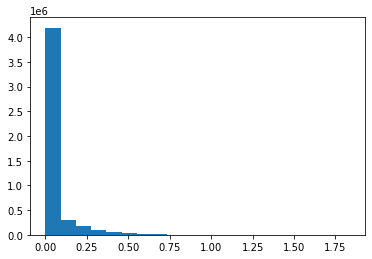

In [201]:
import numpy as np
import matplotlib.pyplot as plt

file = '/home/jovyan/share/gns_data/Concrete2D-I-mps/test.npz'
#print(np.load(file, allow_pickle=True).items())

a = np.array([])
for key, value in np.load(file, allow_pickle=True).items():
    a = np.concatenate((a, value[2].reshape(-1)), axis=0)

b = a[a<0]
print(a.shape, a.min(), a.max())
print(b.shape, b.min(), b.max())
c = plt.hist(a, bins=20)
for i in range(20):
    print(c[1][i], c[0][i]/len(a))

In [77]:
s = r'1.0802397e+00  -4.0000000E+00   0.0000000e+00'
s1 = r'       1  -1.5875000e+02   1.2500000e+00   0.0000000e+00'
a = re.findall(r'[-+\d\.Ee]+', s)
a

['1.0802397e+00', '-4.0000000E+00', '0.0000000e+00']

## Plot particle movement 2D

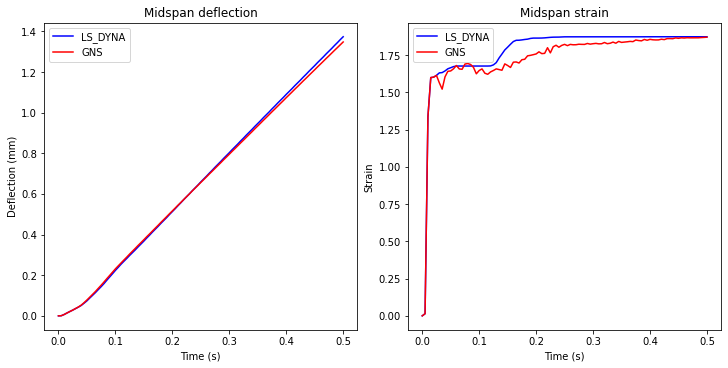

In [202]:
import pickle

from absl import app

from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

rollout_path = "/home/jovyan/work/gns/rollouts/Concrete2D-C/rollout_9.pkl"
output_path = "/home/jovyan/work/gns/rollouts/Concrete2D-C/rollout_9.gif"
step_stride = 3
block_on_show = True

MAX = np.array([325, 95])
MIN = np.array([-325, -15])
strain_min = 0
strain_max = 2
TYPE_TO_COLOR = {
    3: "black",  # Boundary particles. kinematic
    2: "red",  # support
    1: "blue", # concrete
}

MID_SPAN_ID = [2032, 2033, 2064, 2065] ## for 320
MID_SPAN_ID = [3056, 3057, 3088, 3089] ## for 480

def main():
    with open(rollout_path, "rb") as file:
        rollout_data = pickle.load(file)
        
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,5))
    
    plot_info = []
    mid_node = {}
    mid_node_strain = {}
    for ax_i, (label, rollout_field) in enumerate(
      [("Reality", "ground_truth_rollout"),
       ("GNS", "predicted_rollout")]):
    # Append the initial positions to get the full trajectory.
        trajectory = np.concatenate([
            rollout_data["initial_positions"],
            rollout_data[rollout_field]], axis=0)

        trajectory = trajectory * (MAX - MIN) + MIN ## qilin   
        # mid_node[label] = sum(trajectory[:, MID_SPAN_ID, :])/len(MID_SPAN_ID)
        mid_node[label] = (trajectory[:, 3056, :] + trajectory[:, 3057, :] + trajectory[:, 3088, :] + trajectory[:, 3089, :]) /4
        
        if label == 'Reality':
            mid_node_strain[label] = (rollout_data["ground_truth_strain"][:, 3056] + rollout_data["ground_truth_strain"][:, 3057] + 
                                      rollout_data["ground_truth_strain"][:, 3088] + rollout_data["ground_truth_strain"][:, 3089]) / 4
        else:
            mid_node_strain[label] = (rollout_data["predicted_strain"][:, 3056] + rollout_data["predicted_strain"][:, 3057] + 
                                      rollout_data["predicted_strain"][:, 3088] + rollout_data["predicted_strain"][:, 3089]) / 4
        mid_node_strain[label] = mid_node_strain[label] * (strain_max - strain_min) + strain_min   ## inverse normalisation
        
        bounds = rollout_data["metadata"]["bounds"]
        
        # ax.set_xlim(-200, 200)  ## qilin
        # ax.set_ylim(-3, -5)   ## qilin

        # points = {
        #     particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
        #     for particle_type, color in TYPE_TO_COLOR.items()}
        # plot_info.append((ax, trajectory, points))
    
    num_steps = trajectory.shape[0]
    
    axs[0].plot(np.linspace(0,0.5,101), np.abs(mid_node['Reality'][:, 1] - mid_node['Reality'][0, 1]), 'b')
    axs[0].plot(np.linspace(0,0.5,101), np.abs(mid_node['GNS'][:, 1] - mid_node['Reality'][0, 1]), 'r')
    axs[0].set_title('Midspan deflection')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Deflection (mm)')
    axs[0].legend(['LS_DYNA', 'GNS'])
    
    axs[1].plot(np.linspace(0,0.5,101), mid_node_strain['Reality'], 'b')
    axs[1].plot(np.linspace(0,0.5,101), mid_node_strain['GNS'], 'r')
    axs[1].set_title('Midspan strain')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Strain')
    axs[1].legend(['LS_DYNA', 'GNS'])
    
    # axs[1].plot(np.linspace(0,0.5,101), np.abs(mid_node['Reality'][:, 1] - mid_node['GNS'][:, 1]))
    # axs[1].set_title('Difference')
    # axs[1].set_xlabel('Time (s)')
    # axs[1].set_ylabel('Midspan deflection (mm)')
    
    fig.savefig("2D_midspan_deflection.png")
    
    def update(step_i):
        outputs = []
        for _, trajectory, points in plot_info:
            for particle_type, line in points.items():
                mask = rollout_data["particle_types"] == particle_type
                line.set_data(trajectory[step_i, mask, 0],
                          trajectory[step_i, mask, 1])
                outputs.append(line)
        return outputs

if __name__ == "__main__":
    main()

In [69]:
PARTICLE_TYPES ={
    'B_80_320': {'concrete': (1, 4096), 'kinematic': (4153, 4264), 'support': (4265, 4328)},
    'B_80_480': {'concrete': (1, 6144), 'kinematic': (6181, 6292), 'support': (6293, 6356)},
    'B_80_640': {'concrete': (1, 8192), 'kinematic': (8229, 8340), 'support': (8341, 8404)},
    'R_80_320': {'concrete': (1, 4096), 'kinematic': (4153, 4264), 'support': (4265, 4328)},
    'R_80_480': {'concrete': (1, 6144), 'kinematic': (6181, 6292), 'support': (6293, 6356)},
    'R_80_640': {'concrete': (1, 8192), 'kinematic': (8229, 8340), 'support': (8341, 8404)},
    'S_80_320': {'concrete': (1, 4096), 'kinematic': (4097, 4208), 'support': (4209, 4272)},
    'S_80_480': {'concrete': (1, 6144), 'kinematic': (6145, 6256), 'support': (6257, 6320)},
    'S_80_640': {'concrete': (1, 8192), 'kinematic': (8193, 8304), 'support': (8305, 8368)},
    'C_80_320': {'concrete': (1, 4096), 'kinematic': (4097, 4128), 'support': (4129, 4196)},
    'C_80_480': {'concrete': (1, 6144), 'kinematic': (6145, 6176), 'support': (6177, 6244)},
    'C_80_640': {'concrete': (1, 8192), 'kinematic': (8193, 8224), 'support': (8225, 8292)}
}  

file = 'data/Concrete2D/LSDYNA/C_80_640_Ab_20.txt'

with open(file, 'r') as f:
    lines = f.readlines()

    # Find all "particle position" lines and "plastic strain" lines using key words
pos_lines_start, pos_lines_end = [], []
strain_lines_start, strain_lines_end = [], []
for idx, line in enumerate(lines):
    if line.startswith("*NODE"):
        pos_lines_start.append(idx)
    elif line.startswith("$NODAL_RESULTS"):  # $NODAL_RESULTS,(1d) *INITIAL_VELOCITY_NODE(2d)
        pos_lines_end.append(idx)
    elif line.startswith("$RESULT OF Effective Plastic Strain"):
        strain_lines_start.append(idx)
    elif line.startswith("*END"):  
        strain_lines_end.append(idx)
print(len(pos_lines_end))
# Extact particle positions 
trajectory = []
for line_start, line_end in zip(pos_lines_start, pos_lines_end):
    pos_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
    timestep = []
    for line in pos_lines:
        num_str = re.findall(r'[-\d\.e+]+', line)  # Regular expression findign scitific numbers
        (x, y) = (float(num_str[1]), float(num_str[2]))
        timestep.append((x,y))
    trajectory.append(timestep) 

# Extact particle types
particle_types = []
traj_name = file.split('/')[-1][:8]
pos_lines = lines[pos_lines_start[0]+1:pos_lines_end[0]]
for line in pos_lines:
    num_str = re.findall(r'[-\d\.e+]+', line)
    particle_id = int(num_str[0])
    if particle_id >= PARTICLE_TYPES[traj_name]['concrete'][0] and particle_id <= PARTICLE_TYPES[traj_name]['concrete'][1]:
        particle_types.append(0)   # concrete particles
    elif particle_id >= PARTICLE_TYPES[traj_name]['support'][0] and particle_id <= PARTICLE_TYPES[traj_name]['support'][1]:
        particle_types.append(1)   # boundary particles (rigid)
    elif particle_id >= PARTICLE_TYPES[traj_name]['kinematic'][0] and particle_id <= PARTICLE_TYPES[traj_name]['kinematic'][1]:
        if traj_name.startswith('C'):
            particle_types.append(3)   # kinematic particles
        else:
            particle_types.append(2)   # steel
    else:
        raise ValueError('particle id not defined')

# Extrac effective plastic strain
strains = []
for line_start, line_end in zip(strain_lines_start, strain_lines_end):
    strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
    strains_one_step = []
    for line in strain_lines:
        num_str = re.findall(r'[-+\d\.Ee]+', line)  # the expression matches one or more repetitions of "-", "integer", ".", "E",
        num = float(num_str[1])
        strains_one_step.append(num)
    strains.append(strains_one_step)   

        
pos, type, strain = np.array(trajectory).astype(np.float), np.array(particle_types).astype(np.float), np.array(strains).astype(np.float)
print(pos.shape, type.shape, strain.shape)

238
(238, 8284, 2) (8284,) (238, 8284)


(101, 2) (101,)


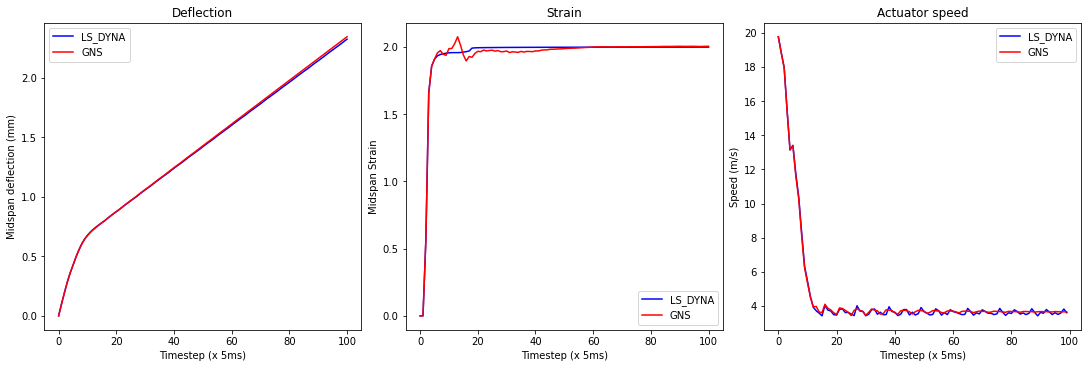

In [127]:
import pickle

from absl import app

from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

rollout_path = "/home/jovyan/work/gns/rollouts/Concrete2D-I-no40/rollout_2.pkl"
output_path = "/home/jovyan/work/gns/rollouts/Concrete2D-I-no40/rollout_2.gif"
step_stride = 3
block_on_show = True

MAX = np.array([325, 95])
MIN = np.array([-325, -15])
strain_min = 0
strain_max = 2

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles. kinematic
    2: "red",  # support
    1: "blue", # concrete
}

MID_SPAN_ID = [6181, 6209, 6237, 6265]

def main():
    with open(rollout_path, "rb") as file:
        rollout_data = pickle.load(file)
        
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
    
    plot_info = []
    mid_node = {}
    mid_node_speed = {}
    mid_node_strain = {}
    for ax_i, (label, rollout_field) in enumerate(
      [("Reality", "ground_truth_rollout"),
       ("GNS", "predicted_rollout")]):
    # Append the initial positions to get the full trajectory.
        trajectory = np.concatenate([
            rollout_data["initial_positions"],
            rollout_data[rollout_field]], axis=0)

        trajectory = trajectory * (MAX - MIN) + MIN ## qilin   
        mid_node[label] = (trajectory[:, 6181, :]+trajectory[:, 6209, :]+trajectory[:, 6237, :]+trajectory[:, 6265, :])/4
        mid_node_speed[label] = np.abs(mid_node[label][1:, :] - mid_node[label][:-1, :]) / 0.005
        if label == 'Reality':
            mid_node_strain[label] = rollout_data["ground_truth_strain"][:, 3057]
        else:
            mid_node_strain[label] = rollout_data["predicted_strain"][:, 3057]
        mid_node_strain[label] = mid_node_strain[label] * (strain_max - strain_min) + strain_min   ## inverse normalisation
        
        bounds = rollout_data["metadata"]["bounds"]
        
        # ax.set_xlim(-200, 200)  ## qilin
        # ax.set_ylim(-3, -5)   ## qilin

        # points = {
        #     particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
        #     for particle_type, color in TYPE_TO_COLOR.items()}
        # plot_info.append((ax, trajectory, points))
    print(mid_node[label].shape, mid_node_strain[label].shape)
    num_steps = trajectory.shape[0]
    
    axs[0].plot(np.abs(mid_node['Reality'][:, 1] - mid_node['Reality'][0, 1]), 'b')
    axs[0].plot(np.abs(mid_node['GNS'][:, 1] - mid_node['Reality'][0, 1]), 'r')
    axs[0].set_title('Deflection')
    axs[0].set_xlabel('Timestep (x 5ms)')
    axs[0].set_ylabel('Midspan deflection (mm)')
    axs[0].legend(['LS_DYNA', 'GNS'])
    
    # axs[1].plot(np.abs(mid_node['Reality'][:, 1] - mid_node['GNS'][:, 1]))
    # axs[1].set_title('Difference')
    # axs[1].set_xlabel('Timestep (x 5ms)')
    # axs[1].set_ylabel('Midspan deflection (mm)')
    
    axs[1].plot(mid_node_strain['Reality'], 'b')
    axs[1].plot(mid_node_strain['GNS'], 'r')
    axs[1].set_title('Strain')
    axs[1].set_xlabel('Timestep (x 5ms)')
    axs[1].set_ylabel('Midspan Strain')
    axs[1].legend(['LS_DYNA', 'GNS'])

    axs[2].plot(mid_node_speed['Reality'][:,1], 'b')
    axs[2].plot(mid_node_speed['GNS'][:,1], 'r')
    axs[2].set_title('Actuator speed')
    axs[2].set_xlabel('Timestep (x 5ms)')
    axs[2].set_ylabel('Speed (m/s)')
    axs[2].legend(['LS_DYNA', 'GNS'])
    # fig.savefig("2D_midspan_deflection.png")
    
    def update(step_i):
        outputs = []
        for _, trajectory, points in plot_info:
            for particle_type, line in points.items():
                mask = rollout_data["particle_types"] == particle_type
                line.set_data(trajectory[step_i, mask, 0],
                          trajectory[step_i, mask, 1])
                outputs.append(line)
        return outputs

if __name__ == "__main__":
    main()

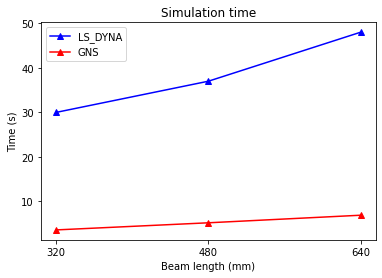

In [161]:
GNN = [3.6, 5.2, 6.9]
DYNA = [30, 37, 48]

plt.plot(DYNA, 'b^-')
plt.plot(GNN, 'r^-')

plt.title('Simulation time')
plt.xlabel('Beam length (mm)')
plt.ylabel('Time (s)')
plt.xticks([0, 1, 2], ['320' ,'480', '640'])
plt.legend(['LS_DYNA', 'GNS'])

In [162]:
"/home/LSDYNA/aaa".replace('LSDYNA', 'LSDYNA_strain')

'/home/LSDYNA_strain/aaa'